# Dynamic BERToic application in detecting Emerging Topics
##### Duration: 2022.10.10-2022.11.16

Mentors: Alex Navarro, Christopher Hawkes

Fellow: Qintong Li

### Project overview 

See table of contents for the notebook outline.

In this project, we explored topic models to detect emerging topics from several terabytes of news corpus. In the early-stage exploration, LDA topic model was used to test on small sub-dataset and implemented as the baseline model. It also provided a baseline standard of model quality to compare with other models of interests. As the exploration of topic models proceeded, some variants of LDA topic models like Dirichlet Multinomial Regression Model and Supervised (LDA) Model. 

With the baseline model, embedding topic models is then applied to the same dataset so that the perfomance of LDA model and embedding topic model can be compared to analyse the pros and cons for each model. One of key concepts of embbeding topic modelis **word embedding**. It convert the meaning of words into vectiors in a semantic space. This means that not only the meaning of words can be represnted by vectors but also the difference between words can be represented by the distance of corresponded vectors. 

The embedding topic model we used in this project is BERTopic model. BERTopic takes advantage of the superior language capabilities of these transformer models and uses some other ML clustering like UMAP and HDBSCAN to produce what is one of the most advanced techniques in topic modeling today.  

This notebook consists of the following parts:
> 1. Data preprocessing in both pandas method and spark-nlp methods. A brief analysis of the advantages and failures of each mothds.
  2. Implementation of a static BERTopic model.
  3. The comparison of model quality between the static BERTopic model and the static LDA model. The model quality is defined as the product of topic coherence score and topic diversity score.
  4. Implementation of dynamic embedding topic model.
  5. Mapping of each topic to the original news website URLs.

### Install and import useful libraries

In [0]:
%pip install bertopic
%pip install octis
%pip install nltk
%pip install gensim==4.0.0
%pip install symspellpy

Python interpreter will be restarted.
Collecting bertopic
 Downloading bertopic-0.12.0-py2.py3-none-any.whl (90 kB)
Collecting hdbscan>=0.8.28
 Downloading hdbscan-0.8.29.tar.gz (5.2 MB)
 Installing build dependencies: started
 Installing build dependencies: finished with status 'done'
 Getting requirements to build wheel: started
 Getting requirements to build wheel: finished with status 'done'
 Preparing wheel metadata: started
 Preparing wheel metadata: finished with status 'done'
Requirement already satisfied: pandas>=1.1.5 in /databricks/python3/lib/python3.8/site-packages (from bertopic) (1.2.4)
Requirement already satisfied: scikit-learn>=0.22.2.post1 in /databricks/python3/lib/python3.8/site-packages (from bertopic) (0.24.1)
Collecting umap-learn>=0.5.0
 Downloading umap-learn-0.5.3.tar.gz (88 kB)
Collecting sentence-transformers>=0.4.1
 Downloading sentence-transformers-2.2.2.tar.gz (85 kB)
Collecting tqdm>=4.41.1
 Downloading tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
Requirement already satisfied: numpy>=1.20.0 in /databricks/python3/lib/python3.8/site-packages (from bertopic) (1.20.1)
Requirement already satisfied: plotly>=4.7.0 in /databricks/python3/lib/python3.8/site-packages (from bertopic) (5.5.0)
Collecting pyyaml<6.0
 Downloading PyYAML-5.4.1-cp38-cp38-manylinux1_x86_64.whl (662 kB)
Requirement already satisfied: scipy>=1.0 in /databricks/python3/lib/python3.8/site-packages (from hdbscan>=0.8.28->bertopic) (1.6.2)
Requirement already satisfied: cython>=0.27 in /databricks/python3/lib/python3.8/site-packages (from hdbscan>=0.8.28->bertopic) (0.29.23)
Requirement already satisfied: joblib>=1.0 in /databricks/python3/lib/python3.8/site-packages (from hdbscan>=0.8.28->bertopic) (1.0.1)
Requirement already satisfied: pytz>=2017.3 in /databricks/python3/lib/python3.8/site-packages (from pandas>=1.1.5->bertopic) (2020.5)
Requirement already satisfied: python-dateutil>=2.7.3 in /databricks/python3/lib/python3.8/site-packages (from pandas>=1.1.5->bertopic) (2.8.1)
Requirement already satisfied: tenacity>=6.2.0 in /databricks/python3/lib/python3.8/site-packages (from plotly>=4.7.0->bertopic) (8.0.1)
Requirement already satisfied: six in /databricks/python3/lib/python3.8/site-packages (from plotly>=4.7.0->bertopic) (1.15.0)
Requirement already satisfied: threadpoolctl>=2.0.0 in /databricks/python3/lib/python3.8/site-packages (from scikit-learn>=0.22.2.post1->bertopic) (2.1.0)
Collecting transformers<5.0.0,>=4.6.0
 Downloading transformers-4.24.0-py3-none-any.whl (5.5 MB)
Collecting torch>=1.6.0
 Downloading torch-1.13.0-cp38-cp38-manylinux1_x86_64.whl (890.2 MB)
Collecting torchvision
 Downloading torchvision-0.14.0-cp38-cp38-manylinux1_x86_64.whl (24.3 MB)
Collecting nltk
 Downloading nltk-3.7-py3-none-any.whl (1.5 MB)
Collecting sentencepiece
 Downloading sentencepiece-0.1.97-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
Collecting huggingface-hub>=0.4.0
 Downloading huggingface_hub-0.10.1-py3-none-any.whl (163 kB)
Requirement already satisfied: filelock in /usr/local/lib/python3.8/dist-packages (from huggingface-hub>=0.4.0->sentence-transformers>=0.4.1->bertopic) (3.6.0)
Collecting typing-extensions>=3.7.4.3
 Downloading typing_extensions-4.4.0-py3-none-any.whl (26 kB)
Requirement already satisfied: requests in /databricks/python3/lib/python3.8/site-packages (from huggingface-hub>=0.4.0->sentence-transformers>=0.4.1->bertopic) (2.25.1)
Requirement already satisfied: packaging>=20.9 in /databricks/python3/lib/python3.8/site-packages (from huggingface-hub>=0.4.0->sentence-transformers>=0.4.1->bertopic) (20.9)
Requirement already satisfied: pyparsing>=2.0.2 in /databricks/python3/lib/python3.8/site-packages (from packaging>=20.9->huggingface-hub>=0.4.0->sentence-transformers>=0.4.1->bertopic) (2.4.7)
Collecting nvidia-cuda-runtime-cu11==11.7.99
 Downloading nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl (849 kB)
Collecting nvidia-cudnn-cu11==8.5.0.96
 Downloading nvidia_cudnn_cu11-8.5

In [0]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups
from tqdm import tqdm

from functools import reduce
from pyspark.sql import DataFrame

from datetime import date
import pandas as pd
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data] Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data] Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
Out[1]: True

### Importing data from 220901-2209031
* sample 0.25 of the whole dataset

In [0]:
from pyspark.sql.functions import lit
from pyspark.sql.functions import col

DATE_FMT = "year=%Y/month=%m/day=%d" # Read single day
PATHS = [
    f"s3://thetradedesk-useast-hadoop/Data_Science/omniscience/traffic/aggregated/{date(year=2022, month=9, day=x).strftime(DATE_FMT)}/"
    for x in range(1,31) # the days you want
]

# df = spark\
#     .read\
#     .parquet(*PATHS)
df_sampled = []
lengths_per_date = []
for i, dates in zip(PATHS, range(1,31)):
  df = spark\
      .read\
      .parquet(i)
  df_sampled_i = df.sample(0.25,233)
  df_sampled_j = df_sampled_i.withColumn("date", lit(date(year=2022, month=9, day=dates)).cast("timestamp"))
#   df_pd_i = df_sampled_i.toPandas()
  lengths_per_date.append(df_sampled_j.count())
  df_sampled.append(df_sampled_j)
df_new = reduce(DataFrame.unionAll, df_sampled)

In [0]:
df_new.write.parquet("/dbfs/mnt/Data_Science/Qintong/one_month_sampled_with_dates")

### Data Preprocessing

#### Spark_nlp preprocessing on Spark SQL Dataframe

We need **install two libraries** for spark-nlp: 
> 1. library source: Maven
      package name: com.johnsnowlabs.nlp:spark-nlp_2.12:4.2.2
  2. library sorce: Pypl
      package name: spark-nlp

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()

sparkDF=df_new

text_col = 'text'
review_text = sparkDF.select(text_col).filter(F.col(text_col).isNotNull())

In [0]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

documentAssembler = DocumentAssembler().setInputCol("text").setOutputCol("document")

In [0]:
from sparknlp.annotator import Tokenizer
tokenizer = Tokenizer() \
     .setInputCols(['document']) \
     .setOutputCol('tokenized')

In [0]:
from sparknlp.annotator import Normalizer
normalizer = Normalizer() \
     .setInputCols(['tokenized']) \
     .setOutputCol('normalized') \
     .setLowercase(True)

In [0]:
from sparknlp.annotator import LemmatizerModel
lemmatizer = LemmatizerModel.pretrained() \
     .setInputCols(['normalized']) \
     .setOutputCol('lemmatized')

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [0]:
from nltk.corpus import stopwords
eng_stopwords = stopwords.words('english')

In [0]:
from sparknlp.annotator import StopWordsCleaner
stopwords_cleaner = StopWordsCleaner() \
     .setInputCols(['lemmatized']) \
     .setOutputCol('no_stop_lemmatized') \
     .setStopWords(eng_stopwords)

In [0]:
from sparknlp.annotator import PerceptronModel
pos_tagger = PerceptronModel.pretrained('pos_anc') \
     .setInputCols(['document', 'lemmatized']) \
     .setOutputCol('pos')

pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]


In [0]:
from sparknlp.annotator import Chunker
# allowed_tags = ['<JJ>+<NN>', '<NN>+<NN>']
allowed_tags = ['<NN>']
chunker = Chunker() \
     .setInputCols(['document', 'pos']) \
     .setOutputCol('ngrams') \
     .setRegexParsers(allowed_tags)

In [0]:
from sparknlp.base import Finisher
finisher = Finisher() \
     .setInputCols([ 'ngrams'])

In [0]:
from pyspark.ml import Pipeline
pipeline = Pipeline() \
     .setStages([documentAssembler,
                 tokenizer,
                 normalizer,
                 lemmatizer,
                 stopwords_cleaner,
                 pos_tagger,
                 chunker,
                 finisher])

In [0]:
processed_review = pipeline.fit(review_text).transform(review_text)

#### Customised preprocessing on Pandas Dataframe

In [0]:
df_pd = df_new.toPandas()

In [0]:
# stop_words = list(stopwords.words('english'))

# new_list = [i.capitalize() for i in stop_words]
  
# new_list.extend(['said','like','would','-','—'])

# stop_words.extend(new_list)

In [0]:
# from typing import List, Iterator, Iterable
# import string


# def tokenise(text: str) -> List[str]:
#     return text.translate(str.maketrans('', '', string.punctuation)).split()
        
# def remove_stopwords(list_text: List[str]) -> List[str]:
#     rv_word = []
#     for word in list_text:
#       if word not in stop_words:
#         rv_word.append(word)
#     return rv_word
# #         yield word

# def lemmatise(list_text: List[str]) -> List[str]:
#     lemma = []
#     for word in list_text:
#       lemma.append(WordNetLemmatizer().lemmatize(word))
#     return lemma


# def process_list_str(item: str) -> List[str]:
# #     out=lemmatise(remove_stopwords(tokenise(item)))
#     out=remove_stopwords(tokenise(item))
#     return out
# #         yield list(out)

In [0]:
# rdd=spark.sparkContext.parallelize(df_new['text'])
# cleaned_rdd = rdd.map(lambda x: process_list_str(x))
# print(cleaned_rdd.take(10))

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 <command-1351222034242257> in <module> 
 1 rdd = spark . sparkContext . parallelize ( df_pd [ 'text' ] ) 
 2 cleaned_rdd = rdd . map ( lambda x : lemmatise ( x ) ) 
 ----> 3 print ( cleaned_rdd . take ( 10 ) ) 

 /databricks/spark/python/pyspark/rdd.py in take (self, num) 
 1598 
 1599 p = range ( partsScanned , min ( partsScanned + numPartsToTry , totalParts ) ) 
 -> 1600 res = self . context . runJob ( self , takeUpToNumLeft , p ) 
 1601 
 1602 items += res

 /databricks/spark/python/pyspark/context.py in runJob (self, rdd, partitionFunc, partitions, allowLocal) 
 1333 finally : 
 1334 os . remove ( filename ) 
 -> 1335 sock_info = self . _jvm . PythonRDD . runJob ( self . _jsc . sc ( ) , mappedRDD . _jrdd , partitions ) 
 1336 return list ( _load_from_socket ( sock_info , mappedRDD . _jrdd_deserializer ) ) 
 1337 

 /databricks/spark/python/lib/py4j-0.10.9.1-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1302 
 1303 answer = self . gateway_client . send_command ( command ) 
 -> 1304 return_value = get_return_value(
 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 115 def deco ( * a , ** kw ) : 
 116 try : 
 --> 117 return f ( * a , ** kw ) 
 118 except py4j . protocol . Py4JJavaError as e : 
 119 converted = convert_exception ( e . java_exception ) 

 /databricks/spark/python/lib/py4j-0.10.9.1-src.zip/py4j/protocol.py in get_return_value (answer, gateway_client, target_id, name) 
 324 value = OUTPUT_CONVERTER [ type ] ( answer [ 2 : ] , gateway_client ) 
 325 if answer [ 1 ] == REFERENCE_TYPE : 
 --> 326 raise Py4JJavaError(
 327 "An error occurred while calling {0}{1}{2}.\n" . 
 328 format(target_id, ".", name), value)

 Py4JJavaError : An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 133.0 failed 4 times, most recent failure: Lost task 0.3 in stage 133.0 (TID 1032) (10.105.210.164 executor 1): org.apache.spark.api.python.PythonException: 'LookupError: 
**********************************************************************
 Resource wordnet not found.
 Please use the NLTK Downloader to obtain the resource:

 >>> import nltk
 >>> nltk.download('wordnet')
 
 For more information see: https://www.nltk.org/data.html

 Attempted to load corpora/wordnet 

 Searched in:
 - '/root/nltk_data'
 - '/local_disk0/.ephemeral_nfs/envs/pythonEnv-b86d3494-f7a5-4847-b718-9220e50deaf4/nltk_data'
 - '/local_disk0/.ephemeral_nfs/envs/pythonEnv-b86d3494-f7a5-4847-b718-9220e50deaf4/share/nltk_data'
 - '/local_disk0/.ephemeral_nfs/envs/pythonEnv-b86d3494-f7a5-4847-b718-9220e50deaf4/lib/nltk_data'
 - '/usr/share/nltk_data'
 - '/usr/local/share/nltk_data'
 - '/usr/lib/nltk_data'
 - '/usr/local/lib/nltk_data'
**********************************************************************', from <command-1351222034242069>, line 19. Full traceback below:
Traceback (most recent call last):
 File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-b86d3494-f7a5-4847-b718-9220e50deaf4/lib/python3.8/site-packages/nltk/corpus/util.py", line 84, in __load
 root = nltk.data.find(f"{self.subdir}/{zip_name}")
 File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-b86d3494-f7a5-4847-b718-9220e50deaf4/lib/python3.8/site-packages/nltk/data.py", line 583, in find
 raise LookupError(resource_not_found)
LookupError: 
**********************************************************************
 Resource wordnet not found.
 Please use the NLTK Downloader to obtain the resource:

 >>> import nltk
 >>> nltk.download('wordnet')
 
 For more information see: https://www.nltk.org/data.html

 Attempted to load corpora/wordnet.zip/wordnet/ 

 Searched in:
 - '/root/nltk_data'
 - '/local_disk0/.ephemeral_nfs/envs/pythonEnv-b86d3494-f7a5-4847-b718-9220e50deaf4/nltk_data

In [0]:
# cleaned_text = cleaned_rdd.toPandas()

`cleaned_text` is the preprocessed text that we can use as the input of `joining()` in the next section.

#### Preparing Pandas dataframe for BERTopic model

In [0]:
df_pd_new = processed_review.toPandas()

In [0]:
def joining(text):
  for i in range(len(text)):
    s = ' '.join(text[i])
    yield s

In [0]:
joined_text = joining(df_pd_new['finished_ngrams'].values)

In [0]:
joined_text_b = list(joined_text)

## Fit BERTopic model

Bertopic is a pre-trained model. Therefore, it is difficult to implement distributed computing with this model. If we fit the model to the whole data set, it can take days to complete the jobs. Here for convenience, we only apply the first 1000 dataset for testing.

In [0]:
topic_model = BERTopic(min_topic_size=70, n_gram_range=(1,3), verbose=True)

In [0]:
topics, _ = topic_model.fit_transform(joined_text_b[:1000])

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2022-11-14 16:40:43,996 - BERTopic - Transformed documents to Embeddings
2022-11-14 16:40:54,035 - BERTopic - Reduced dimensionality
2022-11-14 16:40:54,082 - BERTopic - Clustered reduced embeddings


In [0]:
topic_model.get_topics()

Out[30]: {-1: [('trump', 0.015894994766619715),
  ('time', 0.009940773291205202),
  ('documents', 0.009247698639499927),
  ('season', 0.008095175533574712),
  ('team', 0.007847508557558013),
  ('news', 0.007835299488104769),
  ('games', 0.0074058044737584025),
  ('president', 0.007033483863562177),
  ('home', 0.006953079662585051),
  ('way', 0.006394539779508909)],
 0: [('weinberg', 0.04320163205143738),
  ('police', 0.03481259038511485),
  ('officer', 0.017845997822867533),
  ('according', 0.016260749219503802),
  ('video', 0.0157992876156557),
  ('bidwell', 0.01531606340352188),
  ('parker', 0.014254429816919911),
  ('officers', 0.01331600188062481),
  ('man', 0.012596697223620114),
  ('crum', 0.012094758572932605)],
 1: [('beach', 0.01721670770019944),
  ('restaurant', 0.011757017556112219),
  ('fort', 0.01122097435829037),
  ('advertisement', 0.010905255066362638),
  ('fort lauderdale', 0.010460772856044643),
  ('lauderdale', 0.010460772856044643),
  ('palm', 0.009886231560736201),

### Fit model to given texts and generate topics over time

In [0]:
topics_over_time = topic_model.topics_over_time(joined_text_b[:1000], df_pd['date'][:1000])

1it [00:00,  1.64it/s]


The following two cells are the result running on a quater of 1 month data.

In [0]:
# topics_over_time_test = topic_model.topics_over_time(joined_text_b, dates)

30it [19:28:12, 2336.43s/it]


In [0]:
# topic_model.visualize_topics_over_time(topics_over_time_test.head(10200))

### Save topics over time in CSV and Parquet format.

In [0]:
# topics_over_time.to_csv("/dbfs/mnt/Data_Science/Qintong/BERTopics_over_time_v1_test")

In [0]:
# from pyspark.sql import SparkSession
# spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()

# tp_over_time=spark.createDataFrame(topics_over_time_test) 
# tp_over_time.printSchema()
# tp_over_time.show()

root
 |-- Topic: long (nullable = true)
 |-- Words: string (nullable = true)
 |-- Frequency: long (nullable = true)
 |-- Timestamp: timestamp (nullable = true)

+-----+--------------------+---------+-------------------+
|Topic|               Words|Frequency|          Timestamp|
+-----+--------------------+---------+-------------------+
|   -1|94, aug, new, yea...|     3340|2022-09-01 00:00:00|
|    0|england petrol, p...|      156|2022-09-01 00:00:00|
|    1|            , , , , |      164|2022-09-01 00:00:00|
|    2|inning, previous ...|       77|2022-09-01 00:00:00|
|    3|arsenal, transfer...|      241|2022-09-01 00:00:00|
|    4|crash, vehicle, p...|       40|2022-09-01 00:00:00|
|    5|worldstar better ...|       35|2022-09-01 00:00:00|
|    6|shooting, police,...|       42|2022-09-01 00:00:00|
|    7|fire, blaze, smok...|       42|2022-09-01 00:00:00|
|    9|kejriwal, cbi, bj...|       28|2022-09-01 00:00:00|
|   10|suryakumar, asia ...|       19|2022-09-01 00:00:00|
|   11|doj fi

In [0]:
# tp_over_time.write.parquet("/dbfs/mnt/Data_Science/Qintong/BERTopics_over_time_v1")

In [0]:
t_1 = spark.read.parquet("/dbfs/mnt/Data_Science/Qintong/BERTopics_over_time_v1")

In [0]:
display(t_1)

Topic Words Frequency Timestamp 547 ou football, ou, utep, ou utep, sooners 2 2022-09-03T00:00:00.000+0000 553 meg, netflix, role, crown, play prince 8 2022-09-03T00:00:00.000+0000 554 soul cap, thick curly, cap, hair, contain protect dreadlock 1 2022-09-03T00:00:00.000+0000 556 pixel, konchalovsky, pixel pro, simonyan, satellite 2 2022-09-03T00:00:00.000+0000 559 health associates, womens health associates, vigneri, wyoming, myers 1 2022-09-03T00:00:00.000+0000 563 rings, rings power, jellicle, elf, lord rings 3 2022-09-03T00:00:00.000+0000 564 chile, constitution, zaya, indigenous, boric 3 2022-09-03T00:00:00.000+0000 567 parking boot, beckham, agiye, parking, texas 1 2022-09-03T00:00:00.000+0000 574 greene, hitler, american jewish, diplomat, israeli diplomat 2 2022-09-03T00:00:00.000+0000 578 91, aug, 89, sept, aug 27 13 2022-09-03T00:00:00.000+0000 581 singapore, afn, doping, games, athlete 4 2022-09-03T00:00:00.000+0000 585 derrina, gemma, simon, couric, cancer 2 2022-09-03T00:00:00.000+0000 586 station, railway, train, sabarmati, square metre 3 2022-09-03T00:00:00.000+0000 588 pakistan, india, hong kong, kong, hong 4 2022-09-03T00:00:00.000+0000 595 former president united, warrant, search warrant, search, president united states 2 2022-09-03T00:00:00.000+0000 599 kardashian, kutcher, cortege, peloton, parliament house canberra 1 2022-09-03T00:00:00.000+0000 607 mumtaz, sharmila tagore, sharmila, mansoor, tagore 4 2022-09-03T00:00:00.000+0000 608 willow, general hospital, credit abc screenshot, abc screenshot, credit abc 14 2022-09-03T00:00:00.000+0000 617 azad, ghulam nabi, ghulam, bukhari, nabi azad 4 2022-09-03T00:00:00.000+0000 620 india, pakistan, pant, team india, view stated 5 2022-09-03T00:00:00.000+0000 626 sankey, 12team, playoff, cfp, commissioner 1 2022-09-03T00:00:00.000+0000 629 city pearland, port houston, pearland, roberson, jones 1 2022-09-03T00:00:00.000+0000 630 2019s loss mountaineers, started carolina look, row tar heels, ridge mountains storm, row tar 1 2022-09-03T00:00:00.000+0000 631 krishnan, civil liberty, oath keepers, keepers, oath 5 2022-09-03T00:00:00.000+0000 635 andrade, espinoza, tolleson, hobbs, writein 5 2022-09-03T00:00:00.000+0000 639 xfinity, pm et usa, et usa network, et usa, xfinity series 3 2022-09-03T00:00:00.000+0000 656 sorry blog currently, currently unavailable please, sorry blog, blog currently, unavailable please try 7 2022-09-03T00:00:00.000+0000 667 mr markle, markle, harry, blood clot, clot 5 2022-09-03T00:00:00.000+0000 671 yankees, judge, degrom, free agency, million 3 2022-09-03T00:00:00.000+0000 673 betis, laliga, rodrygo, real betis, real madrid 41 2022-09-03T00:00:00.000+0000 674 poyer, bills, sobleski, sobleski wrote, former bills 1 2022-09-03T00:00:00.000+0000 676 fetterman, debate, oz, auditory processing, auditory 3 2022-09-03T00:00:00.000+0000 680 report gisele, compound florida jetted, rica blowout fight, gisele brady couple, couple therapy big 3 2022-09-03T00:00:00.000+0000 687 kiwi farms, farms, kiwi, cloudflare, cloudflares 4 2022-09-03T00:00:00.000+0000 688 threat, rep, violence, lawmaker, butterfield 1 2022-09-03T00:00:00.000+0000 689 dicaprio, leonardo dicaprio, leonardo, leos, age gap 15 2022-09-03T00:00:00.000+0000 701 cherry, kanye, adidas, cherry iii, daniel cherry iii 9 2022-09-03T00:00:00.000+0000 702 miss manners, manners, dear miss, dear miss manners, miss 1 2022-09-03T00:00:00.000+0000 709 sri, lanka, sri lanka, afghanistan, cup match sri 5 2022-09-03T00:00:00.000+0000 710 truss, duncan smith, party, tory, parliamentary 2 2022-09-03T00:00:00.000+0000 712 davis wade stadium, stadium scott field, wade stadium scott, scott field, davis wade 1 2022-09-03T00:00:00.000+0000 714 illinois email esimmonsnewsgazettecom, reporter newsgazette covering, email esimmonsnewsgazettecom follow, ethancsimmons, university illinois email 2 2022-09-03T00:00:00.000+0000 727 wordle, word, letter, answer, wordle answer 8 2022-09-03T00:00:00.000+0000 732 corbin, smackdo

## Model evaluation

We compare the D-LDA and D-ETM according to to metrics:
* perplexity on a document completion task
* topic quality

1. Perplexity: obtained by computing the probability of each word in the second half of a test document, conditioned on the first half.
2. Topic quality: To obtain the topic quality, we combine two metrics. The first metric is topic coherence; it provides a quantitative measure of the interpretability of a topic. We obtain the topic coherence by taking the average pointwise mutual information of two words drawn randomly from the same document; this requires to approximate word probabilities with empirical counts. The second metric is topic diversity; it is the percentage of unique words in the top 25 words of all topics. Diversity close to 0 indicates redundant topics. We obtain both topic coherence and topic diversity by averaging over time. Finally, topic quality is defined as the product between topic coherence and diversity.

#### Topic Diversity

In [0]:
import octis
from octis.evaluation_metrics.diversity_metrics import TopicDiversity

In [0]:
topics = [x.split(",") for x in topics_over_time['Words'].values]
d = {'topics':topics}

bert_output = pd.DataFrame(d)

d_metric = TopicDiversity(topk=5) # Initialize metric
topic_diversity_score = d_metric.score(bert_output) # Compute score of the metric

In [0]:
print('the topic diversity score of D-ETM is: {:0.3f}'.format(topic_diversity_score))

the topic diversity score of D-ETM is: 1.000


#### Topic Coherence

In [0]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary

cleaned_text = df_pd_new['finished_ngrams'].values
dct = Dictionary(topics)
#############################
# SLIDING_WINDOW_SIZES = {###
#     'c_v': 110,     #######
#     'c_w2v': 5,     #######
#     'c_uci': 10,   ########
#     'c_npmi': 10,  ########
#     'u_mass': None   ######
# }                  ########
#############################

cm = CoherenceModel(topics=topics, texts = cleaned_text, dictionary=dct, coherence='c_v')

coherence_per_topic = cm.get_coherence_per_topic()  # get coherence value
cleanedcs = [x for x in coherence_per_topic if str(x) != 'nan']
coherence = np.mean(cleanedcs)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-711d975c-9756-4084-af98-85f1a5a8f1d1/lib/python3.9/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-711d975c-9756-4084-af98-85f1a5a8f1d1/lib/python3.9/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))
/databricks/python/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/databricks/python/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [0]:
print('the topic coherence score of D-ETM is: {:0.3f}'.format(coherence))

the topic coherence score of D-ETM is: nan


### Visualization of topic quality for static LDA and static BERTopic models

This section used the hand-typed results from other notebook.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
labels = ['16k', '32k']
x_v_b = [16000,32000]
widths = 1000
x = np.arange(len(labels))
y_lda_d = [0.496,0.442]
y_ber_d = [0.587,0.596]
y_lda_c = [0.399,0.504]
y_ber_c = [0.355,0.404]

y_d = [0.596,0.442]
y_c = [-5.994, -3.205]
y_lda = [0.442,-3.205]
y_bert = [0.596,-5.994]

Out[40]: <matplotlib.legend.Legend at 0x7f5ec00aae80>

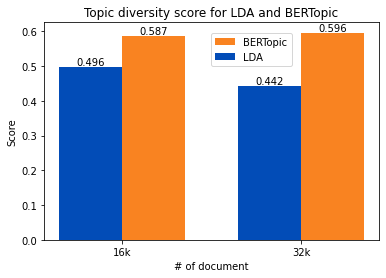

In [0]:
fig, ax = plt.subplots()
labels = ['16k', '32k']
widths = 0.35
x = np.arange(len(labels))
rects1 = ax.bar(x+widths/2,y_ber_d,width = widths,label = 'BERTopic',color = '#F98321')
rects2 = ax.bar(x-widths/2,y_lda_d,width = widths,label = 'LDA', color = '#024CB7')
plt.title('Topic diversity score for LDA and BERTopic')
plt.ylabel('Score')
plt.xlabel('# of document')
ax.bar_label(rects1, padding=0)
ax.bar_label(rects2, padding=0)
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.legend(loc=[0.5,0.8])

Out[41]: <matplotlib.legend.Legend at 0x7f5eec12bd30>

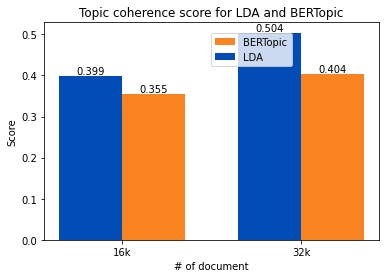

In [0]:
fig, ax = plt.subplots()
labels = ['16k', '32k']
widths = 0.35
x = np.arange(len(labels))
rects1 = ax.bar(x+widths/2,y_ber_c,width = widths,label = 'BERTopic',color = '#F98321')
rects2 = ax.bar(x-widths/2,y_lda_c,width = widths,label = 'LDA', color = '#024CB7')
plt.title('Topic coherence score for LDA and BERTopic')
plt.ylabel('Score')
plt.xlabel('# of document')
ax.bar_label(rects1, padding=0)
ax.bar_label(rects2, padding=0)
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.legend(loc=[0.5,0.8])

In [0]:
fig, ax = plt.subplots()
labels = ['16k', '32k']
widths = 0.35
x = np.arange(len(labels))
rects1 = ax.bar(x+widths/2,[y_ber_d[0]*y_ber_c[0],y_ber_d[1]*y_ber_c[1]],width = widths,label = 'BERTopic',color = '#F98321')
rects2 = ax.bar(x-widths/2,[y_lda_d[0]*y_lda_c[0],y_lda_d[1]*y_lda_c[1]],width = widths,label = 'LDA', color = '#024CB7')
plt.title('Model quality computed with topic diversity score and topic coherence score \n for LDA and BERTopic')
plt.ylabel('Score')
plt.xlabel('# of document')
ax.bar_label(rects1, padding=0,fmt = '%.3f')
ax.bar_label(rects2, padding=0,fmt = '%.3f')
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.legend()

## Map topics to URLs

In this section, we use symspell package to match the keywords from each topic to the original text. By implementing this, we can finally assign each topic back to the webpage where the texts come from. The topics information are imported from saved file generated by BERTopic model because the topics over time generated for a whole month of data needs ~19 hours.

In [0]:
from symspellpy import (
    SymSpell,
    Verbosity
)
from pyspark.sql import Row

from pyspark.sql.functions import col

from pyspark.sql.types import (
    StructType,
    StructField,
    StringType,
    FloatType
)

### Setup FuzzyMatcher

In [0]:
from typing import List
import pyspark.sql.functions as f

class FuzzyMatcher:

    def __init__(self, entities):
        """
        creates a fuzzy string matching object based on a lsit of known entities
        entities <List[str]>:
        """
        self.matcher = SymSpell(
            max_dictionary_edit_distance=2,
            prefix_length=7,
            count_threshold=1
        )
        self.names = []
        
        for name in entities[0]:
            self.matcher.create_dictionary_entry(name, 1)
        
        self.names.append(entities[1])
#         print(self.names)


    def __call__(self, text: str) -> List[str]:
        entities = set()
        for text_t in text.split(' '):
          if text_t:
              extracted = self.matcher.lookup(
                  text_t, Verbosity.CLOSEST, max_edit_distance=2)

              if extracted:
                  entities.add(extracted[0].term) 
        
        if len(list(entities)) < 3:
            return [' '],[' ']

        else: 
            return list(entities),self.names

### lookup topic keywords over each row

In [0]:
from pyspark.sql.types import LongType, ArrayType, StringType,DoubleType


class KeywordEntityExtractor:

    def __init__(
        self,
        spark,
        dealias_s3_url,
        entities_s3_url
    ):
        """
        extracts entities based on keyword matching for a small number of entities that the
        deep entity linker may not get but the deep entity recognition recognizes.
        - spark <sparkContext>: the spark context to be used
        - news_s3_url <str>: the S3 location of the news dataset in parquet format
        - entities_s3_url <str>: the s3 location of the entities dataset in parquet format
        """
        self.spark = spark

        self.not_matched = self.spark\
            .read\
            .format('parquet')\
            .load(dealias_s3_url)\
            .repartition(1000)


#         print("sanity check", self.not_matched.count())
        UNRECOGNIZED_ENTITY = "UNRECOGNIZED_ENTITY"
  
        self.matched = self.spark\
            .read\
            .format('parquet')\
            .load(dealias_s3_url)\
            .filter(col("entityId") != UNRECOGNIZED_ENTITY)

        self.numPartitions = self.not_matched.rdd.getNumPartitions()
#         print("num partitions", self.numPartitions)
    

        data_f = spark\
            .read\
            .format("parquet")\
            .load("/dbfs/mnt/Data_Science/Qintong/BERTopics_over_time_v1")
        topics_with_ids = data_f.select("Topic","Words")


        columns = [f.col("Topic"), f.col("Words")] 
        output = topics_with_ids.withColumn("topics_id", f.array(columns))
        tp_ids = output.select("topics_id")
        final_topics_with_ids = tp_ids.rdd.collect()


        ent = []
        for it in final_topics_with_ids:
          ent.append([it[0][1].split(','),it[0][0]])


        self.matchers = []
        for k in ent[:10]:
          self.matchers.append(FuzzyMatcher(k))

    def __call__(self):
        """
        extracts the entities from the news articles using the approximate string matching
        """

        matchers = self.matchers

        def lookup_entities(row):

              keyword = []
              topic_ids = []
              for matcher in matchers:
                keyword.append(matcher(row.text)[0])
                topic_ids.append(matcher(row.text)[1])
                
              if keyword == row.entityId:
                  return Row(url=row.url, delta = row.delta, positive = row.positive,neutral=row.neutral,negative=row.negative, rawEntity=row.rawEntity, entityId=keyword, score = topic_ids, entityType=row.entityType, uiidType=row.uiidType, country=row.country, region=row.region, rawCounts=row.rawCounts, trafficCount7Day=row.trafficCount7Day, uiidCounts = row.uiidCounts, uiidDistinctCount7Day = row.uiidDistinctCount7Day, title = row.title,text = row.text, authors = row.authors, tags = row.tags, meta_description = row.meta_description)
              else:
                  return Row(url=row.url, delta = row.delta, positive = row.positive,neutral=row.neutral,negative=row.negative, rawEntity=row.rawEntity, entityId=keyword, score = topic_ids, entityType=row.entityType, uiidType=row.uiidType, country=row.country, region=row.region, rawCounts=row.rawCounts, trafficCount7Day=row.trafficCount7Day, uiidCounts = row.uiidCounts, uiidDistinctCount7Day = row.uiidDistinctCount7Day, title = row.title,text = row.text, authors = row.authors, tags = row.tags, meta_description = row.meta_description)
                

        schema = StructType([
            StructField('url', StringType(), True),
            StructField('delta', FloatType(), True),
            StructField('positive', FloatType(), True),
            StructField('neutral', FloatType(), True),
            StructField('negative', FloatType(), True),
            StructField('rawEntity', StringType(), True),
            StructField('entityId', StringType(), True),
            StructField('score', StringType(), True),          
            StructField('entityType', StringType(), True),
            StructField('uiidType', StringType(), True),
            StructField('country', StringType(), True),
            StructField('region', StringType(), True),
            StructField('rawCounts', LongType(), True),
            StructField('trafficCount7Day', LongType(), True),
            StructField('uiidCounts', LongType(), True),
            StructField('uiidDistinctCount7Day', LongType(), True),
            StructField('title', StringType(), True),
            StructField('text', StringType(), True),
            StructField('authors', ArrayType(StringType()), True),
            StructField('tags', ArrayType(StringType()), True),
            StructField('meta_discription', StringType(), True),
        ])
        
        rdd = self.not_matched\
            .rdd\
            .map(lookup_entities)

        fixed = self.spark.createDataFrame(rdd, schema)

        return fixed


In [0]:
run_1 = KeywordEntityExtractor(spark,"/dbfs/mnt/Data_Science/Qintong/one_month_sampled_with_dates","/dbfs/mnt/Data_Science/Qintong/BERTopics_over_time_v1")

In [0]:
topic_to_URL = run_1()

In [0]:
display(topic_to_URL)

url delta positive neutral negative rawEntity entityId score entityType uiidType country region rawCounts trafficCount7Day uiidCounts uiidDistinctCount7Day title text authors tags meta_discription https://www.cbsnews.com/miami/news/hurricane-ian-forms-forecast-to-rapidly-strengthen-monday/ 0.9262907 0.946888 0.03251466 0.020597339 Ian [[ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ]] [[ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ], [ ]] PER c US Florida 6296 6296 397 397 Hurricane Ian forms, forecast to rapidly strengthen Monday MIAMI - Tropical Storm Ian has strengthened into a hurricane.

The National Hurricane Center's 5 a.m. advisory has the center of the Category 1 hurricane about 315 miles southeast of the western tip of Cuba.

THE LATEST Western Florida and Panhandle at risk of storm landfall.

Florida Keys under tropical storm warning as system nears.

Flooding a possibility in S. Florida as storm enters the Gulf and treks northward.

CBS Miami Hurricane Guide

Guía de preparación para temporada de huracanes

Ian was moving to the northwest at 14 mph with sustained winds of 75 mph.

The storm is expected to strengthen rapidly on Monday and Ian is forecast to become a major hurricane Monday night when it is near western Cuba.

During a Sunday news conference, Gov. Ron DeSantis, who had issued a new executive order that now covers virtually all of the state, said the storm will have "broad impacts throughout the state."

The governor's declaration frees up emergency protective funding and activates members of the Florida National Guard, his office said.

His order stresses that there is a risk for a storm surge, flooding, dangerous winds, and other weather conditions throughout the state.

Hurricane Ian 9-26-2022 5AM NEXT Weather

President Joe Biden also declared an emergency for the state, authorizing the Department of Homeland Security and the Federal Emergency Management Agency, or FEMA, to coordinate disaster relief efforts and provide assistance to protect lives and property. The president postponed a scheduled Sept. 27 trip to Florida due to the storm.

A Hurricane Warning is in effect for Grand Cayman and the Cuban provinces of Isla de Juventud, Pinar del Rio, and Artemisa.

A Hurricane Warning means that hurricane conditions are expected somewhere within the warning area, in this case within 24 to 36 hours.

A Hurricane Watch is in effect for Englewood, Florida to the Anclote River, including Tampa Bay.

A Hurricane Watch means that hurricane conditions are possible within the watch area. A watch is typically issued 48 hours

before the anticipated first occurrence of tropical storm-force winds.

Tropical storm warnings are posted for the Cuban provinces of La Habana, Mayabeque, and Matanzas; the lower Florida Keys from Seven Mile Bridge westward to Key West; and the Dry Tortugas.

A Tropical Storm Watch is in effect for Little Cayman, Cayman Brac, and Englewood southward to Chokoloskee

A Storm Surge Watch is in effect for the Florida Keys from the Card Sound Bridge westward to Key West, the Dry Tortugas, Florida Bay, Anclote River southward to the Card Sound Bridge, and Tampa Bay.

Ian is forecast to take a turn to the north-northwest on Monday followed by a northward motion on Tuesday with a slightly slower forward speed. A turn toward the north-northeast is forecast on Tuesday night or early Wednesday.

On the forecast track, the center of Ian is expected to pass near or west of the Cayman Islands today, and near or over western Cuba tonight and early Tuesday. Ian will then emerge over the southeastern Gulf of Mexico on Tuesday, and pass west of the Florida Keys late Tuesday, and approach the west coast of Florida on Wednesday. List(Cbs Miami Team, The Cbs Miami Team Is A Group Of Experienced Journalists Who Bring You The Content On Cbsmiami.Com.) List(Weather Forecast, Hurricane Preps, Atlantic Hurricane Season) Ian is forecast to become a major hurricane Monday night https://people.com/celebrity/star-tracks-

### Save result for topics mapping

In [0]:
topic_to_URL.write.parquet("/dbfs/mnt/Data_Science/Qintong/topic_to_URLs_run_1st")